<a id="1"></a> 
# Information about the dataset:
Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.

This new dataset has following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.

Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with much less noise as compared to Twitter datasets.

Unlike tweets which are replies to other tweets, the news headlines we obtained are self-contained. This would help us in teasing apart the real sarcastic elements.


# 1. Importing Libraries 

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import nltk
import re
import re,string,unicodedata
from nltk.corpus import stopwords
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")


<a id="3"></a> 
# 2. Loading the Data 📅

In [2]:
import pandas as pd
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


# 3.  Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


In [5]:
df.shape

(28619, 3)

In [6]:
#checking for null values in train data
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
df.describe(include='object')

,headline,article_link
count,28619,28619
unique,28503,28617
top,"'no way to prevent this,' says only nation whe...",https://politics.theonion.com/nation-not-sure-...
freq,12,2


In [8]:
#checking for duplicate values
df['headline'].duplicated().sum()

116

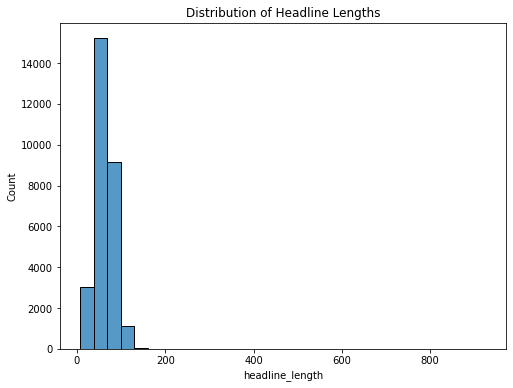

In [12]:
# Analyze headline lengths
df['headline_length'] = df['headline'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='headline_length', bins=30)
plt.title("Distribution of Headline Lengths")
plt.show()

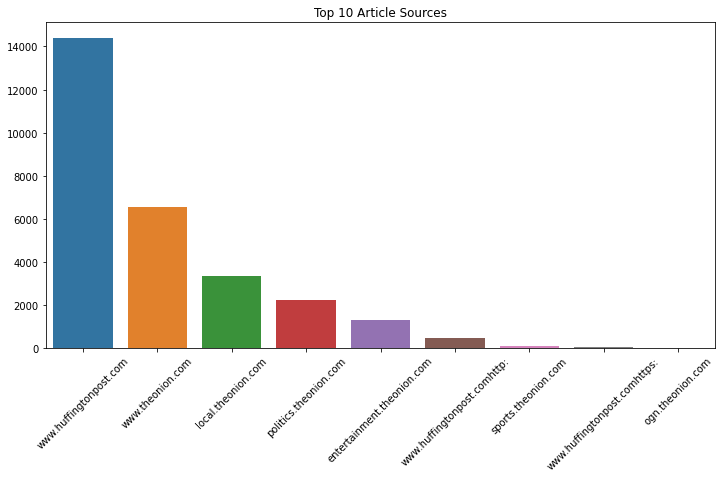

In [13]:
# Explore the source of the articles
source_counts = df['article_link'].apply(lambda x: x.split('/')[2]).value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(x=source_counts.index[:10], y=source_counts.values[:10])
plt.title("Top 10 Article Sources")
plt.xticks(rotation=45)
plt.show()

**Dropping Duplicates**

In [14]:
df=df.drop(df[df['headline'].duplicated()].index,axis=0)

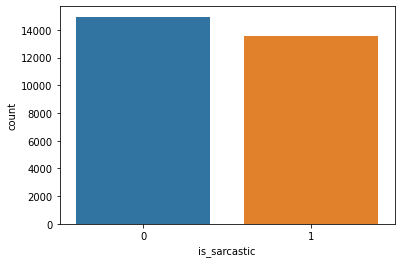

In [15]:
sns.countplot(df['is_sarcastic']);

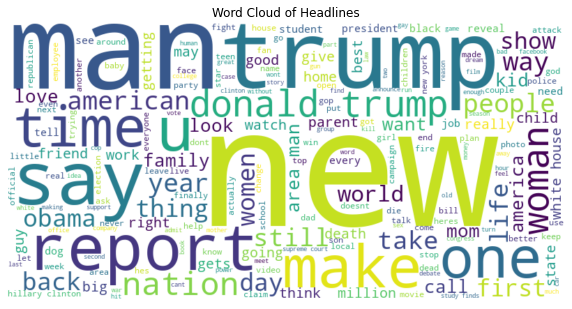

In [35]:
# Combine all headlines into a single text
all_headlines = ' '.join(df['headline'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_headlines)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Headlines")
plt.show()

# 4. Preprocessing  

# 4.A.Stopwords removal

In [16]:
# this function is copied from another kernel. Don't know who is the original author of it.
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [17]:
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

In [18]:
labels = (df['is_sarcastic'])
data = (df['headline'])

# 4.B. Splitting the Data 


In [19]:
train_ratio = 0.80

train_size = int(len(labels)*train_ratio)

train_data = data[:train_size]
train_labels= labels[:train_size]

test_data = data[train_size:]
test_labels = labels[train_size:]


<a id="6"></a> 
# 4.C. Tokenizaton and Padding 

In [20]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)



25662


In [21]:
maxlen=max([len(i) for i in train_sequences])

In [22]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen,  padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen,  padding='post')

## Differnce between normal sentence, tokenized sequence and padded sequence?

In [23]:
# Print a sample headline
index = 10
print(f'sample headline: {train_sequences[index]}')
print(f'padded sequence: {train_padded[index]} \n')

print(f'Original Sentence:  \n {tokenizer.sequences_to_texts(train_sequences[index:index+1])} \n')

# Print dimensions of padded sequences
print(f'shape of padded sequences: {train_padded.shape}')

sample headline: [1972, 2572, 315, 3022, 943, 7]
padded sequence: [1972 2572  315 3022  943    7    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] 

Original Sentence:  
 ['lesbian considered father indiana amazing one'] 

shape of padded sequences: (22802, 106)


# 5. LSTM

In [24]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,100,input_length=maxlen),
    tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 106, 100)          2566300   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,817,309
Trainable params: 2,817,309
Non-trainable params: 0
______________________________________________

In [25]:
history_lstm=model_lstm.fit(train_padded, np.array(train_labels),validation_data = (test_padded,np.array(test_labels)) , epochs = 5 , verbose=2)

Epoch 1/5
713/713 - 14s - loss: 0.4821 - accuracy: 0.7527 - val_loss: 0.4026 - val_accuracy: 0.8186
Epoch 2/5
713/713 - 10s - loss: 0.2107 - accuracy: 0.9163 - val_loss: 0.4492 - val_accuracy: 0.8127
Epoch 3/5
713/713 - 10s - loss: 0.0911 - accuracy: 0.9673 - val_loss: 0.6557 - val_accuracy: 0.8044
Epoch 4/5
713/713 - 10s - loss: 0.0408 - accuracy: 0.9859 - val_loss: 0.8337 - val_accuracy: 0.7979
Epoch 5/5
713/713 - 10s - loss: 0.0219 - accuracy: 0.9924 - val_loss: 0.9833 - val_accuracy: 0.7934


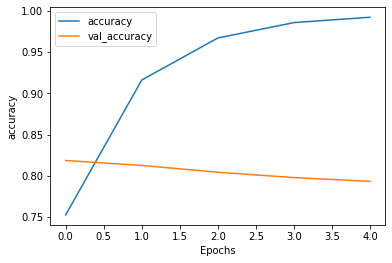

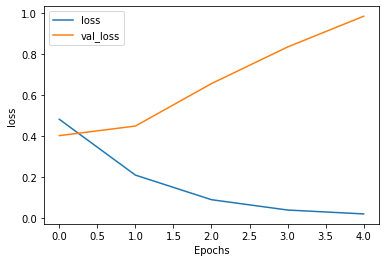

In [26]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history_lstm, "accuracy")
plot_graphs(history_lstm, "loss")

# Gated Recurrent Unit (GRU) Model

In [27]:
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 100, input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 106, 100)          2566300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               176640    
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 2,759,453
Trainable params: 2,759,453
Non-trainable params: 0
____________________________________________

In [28]:
history_gru=model_gru.fit(train_padded, np.array(train_labels),validation_data = (test_padded,np.array(test_labels)) , epochs = 5 , verbose=2)

Epoch 1/5
713/713 - 12s - loss: 0.4792 - accuracy: 0.7588 - val_loss: 0.3996 - val_accuracy: 0.8153
Epoch 2/5
713/713 - 9s - loss: 0.2039 - accuracy: 0.9186 - val_loss: 0.4359 - val_accuracy: 0.8071
Epoch 3/5
713/713 - 9s - loss: 0.0866 - accuracy: 0.9684 - val_loss: 0.6165 - val_accuracy: 0.7948
Epoch 4/5
713/713 - 9s - loss: 0.0421 - accuracy: 0.9862 - val_loss: 0.9292 - val_accuracy: 0.7879
Epoch 5/5
713/713 - 9s - loss: 0.0235 - accuracy: 0.9921 - val_loss: 0.9362 - val_accuracy: 0.7842


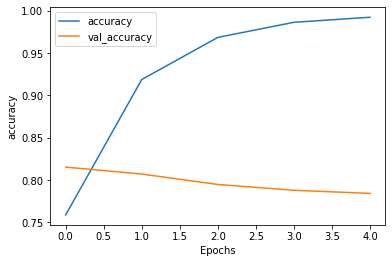

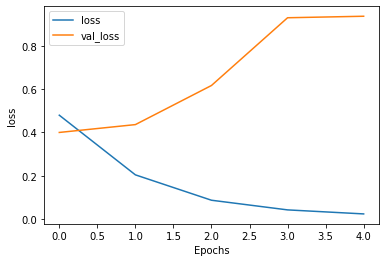

In [29]:
plot_graphs(history_gru, "accuracy")
plot_graphs(history_gru, "loss")

# Convolutional Neural Network (CNN) with LSTM

In [30]:
model_cnn_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size + 1, 100, input_length=maxlen),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 106, 100)          2566300   
_________________________________________________________________
conv1d (Conv1D)              (None, 102, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [31]:
history_cnn_lstm=model_cnn_lstm.fit(train_padded, np.array(train_labels),validation_data = (test_padded,np.array(test_labels)) , epochs = 5 , verbose=2)

Epoch 1/5
713/713 - 9s - loss: 0.5034 - accuracy: 0.7424 - val_loss: 0.4125 - val_accuracy: 0.8048
Epoch 2/5
713/713 - 5s - loss: 0.2007 - accuracy: 0.9200 - val_loss: 0.4733 - val_accuracy: 0.8069
Epoch 3/5
713/713 - 5s - loss: 0.0419 - accuracy: 0.9861 - val_loss: 0.7204 - val_accuracy: 0.8018
Epoch 4/5
713/713 - 5s - loss: 0.0125 - accuracy: 0.9955 - val_loss: 1.0993 - val_accuracy: 0.8025
Epoch 5/5
713/713 - 5s - loss: 0.0061 - accuracy: 0.9979 - val_loss: 1.2733 - val_accuracy: 0.7907


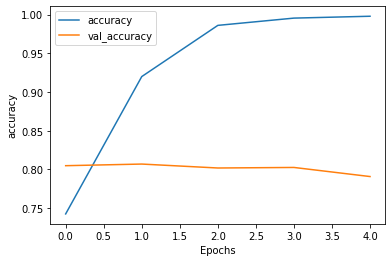

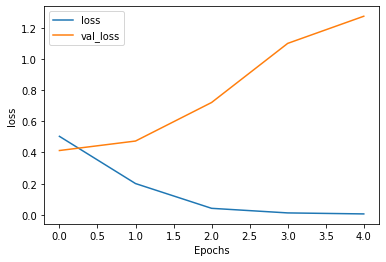

In [32]:
plot_graphs(history_cnn_lstm, "accuracy")
plot_graphs(history_cnn_lstm, "loss")